In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [44]:
df = pd.read_excel(r"C:\Users\User\Desktop\Data Science\Projects Dataset\Fligh prices\Data_Train.xlsx")

In [45]:
pd.set_option("display.max_columns", None)

In [46]:
df.shape

(10683, 11)

In [47]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [48]:
df.dropna(inplace = True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [50]:
df.describe()

,Price
count,10682.000000
mean,9087.214567
std,4611.548810
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


# Data Cleaning

In [51]:
df.Destination

0        New Delhi
1         Banglore
2           Cochin
3         Banglore
4        New Delhi
           ...    
10678     Banglore
10679     Banglore
10680        Delhi
10681    New Delhi
10682       Cochin
Name: Destination, Length: 10682, dtype: object

Since New Delhi is within Delhi, i would combined these two together

In [52]:
def delhi(x):
    if x == "New Delhi":
        return ("Delhi")
    else:
        return (x)

In [53]:
df.Source = df.Source.apply(lambda x : delhi(x))
df.Destination = df.Destination.apply(lambda x : delhi(x))

In [54]:
df["Date_of_Journey"] = pd.to_datetime(df["Date_of_Journey"])

In [55]:
df.Duration

0        2h 50m
1        7h 25m
2           19h
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680        3h
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10682, dtype: object

The Duration is in minutes and hours.To ensure uniformity, i would convert the values in the duration column to minutes

In [56]:
def convert_min(x):
    if len(x.split()) == 1:
        a = int(x.split()[0][:-1])
        a = a * 60
    else:
        b = int(x.split()[0][:-1])
        b = b * 60
        c = int(x.split()[1][:-1])
        a = b + c
    return (a)

In [57]:
df["Duration_Min"] = df.Duration.apply(lambda x : convert_min(x))

In [58]:
df.Source.value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [59]:
df.Destination.value_counts()

Cochin       4536
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [60]:
df.Total_Stops.value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [61]:
df.Additional_Info.value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

# Analyzing the data based on Airline

#### Most Used Airline

<AxesSubplot:>

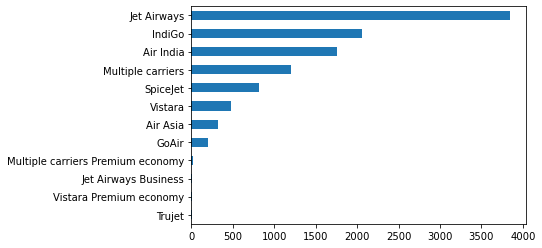

In [62]:
df.Airline.value_counts(sort = True, ascending=True).plot(kind = "barh")

Most used Airline is Jet Airways, followed by IndiGo

#### Airlines That Travelled The Longest Distance

In [63]:
df[["Airline","Duration","Duration_Min", "Route", "Additional_Info", "Price"]][df["Duration_Min"].isin(df.Duration_Min.nlargest(10).tolist())].sort_values(by = "Duration_Min", ascending=False)

,Airline,Duration,Duration_Min,Route,Additional_Info,Price
10456,Jet Airways,47h 40m,2860,DEL → AMD → BOM → COK,No info,20694
1067,Jet Airways,47h,2820,DEL → IDR → BOM → COK,No info,20064
8409,Jet Airways,42h 45m,2565,DEL → JAI → BOM → COK,No info,12819
5953,Jet Airways,42h 5m,2525,DEL → IDR → BOM → COK,No info,11664
7906,Air India,41h 20m,2480,CCU → GAU → DEL → BLR,No info,13990
10326,Air India,40h 20m,2420,BLR → CCU → GAU → DEL,No info,11791
6321,Air India,39h 5m,2345,BLR → BOM → AMD → DEL,No info,17135
9848,Air India,39h 5m,2345,BLR → BOM → AMD → DEL,No info,17135
5701,Air India,38h 35m,2315,BLR → BOM → BHO → DEL,No info,25430
6059,Jet Airways,38h 35m,2315,DEL → MAA → BOM → COK,In-flight meal not included,8098


# Analysis Based On Price 

In [64]:
df[["Airline","Duration","Duration_Min","Route","Additional_Info","Price"]][df["Price"].isin(df.Price.nlargest(10).tolist())].sort_values(by = "Price", ascending=False)

,Airline,Duration,Duration_Min,Route,Additional_Info,Price
2924,Jet Airways Business,5h 40m,340,BLR → BOM → DEL,Business class,79512
5372,Jet Airways Business,6h 40m,400,BLR → BOM → DEL,Business class,62427
10364,Jet Airways Business,4h 40m,280,BLR → MAA → DEL,Business class,57209
1478,Jet Airways,6h 5m,365,BLR → BOM → DEL,No info,54826
2618,Jet Airways,6h 15m,375,BLR → BOM → DEL,No info,54826
5439,Jet Airways,6h 5m,365,BLR → BOM → DEL,No info,54826
9715,Jet Airways Business,8h 20m,500,DEL → ATQ → BOM → COK,No info,52285
657,Jet Airways Business,5h,300,BLR → BOM → DEL,No info,52229
7351,Jet Airways Business,8h 20m,500,DEL → ATQ → BOM → COK,No info,46490
396,Multiple carriers,6h 25m,385,DEL → BOM → COK,No info,36983


From the table above, its obvious that "Jet Airways" airline is expensive compared to other airlines.Jet Airway "Business class" is even more expensive, this indicates that the class play a huge role in determining the price of flight.  

<AxesSubplot:xlabel='Duration_Min', ylabel='Price'>

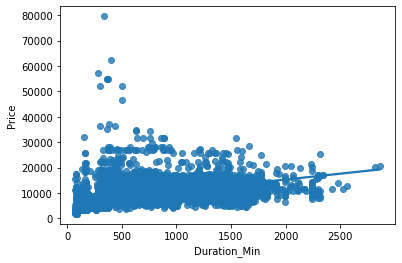

In [65]:
sns.regplot(x = pd.DataFrame(df.Duration_Min), y = df.Price)

Even though the duration doesn't impact the the price of flight as compared to "Class", it still contributes to the overall price of flight

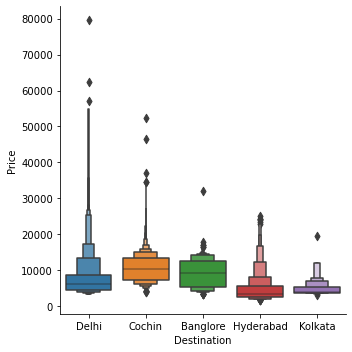

In [66]:
sns.catplot(x = "Destination", y = "Price", data = df.sort_values(by = "Price", ascending=False), kind = "boxen")

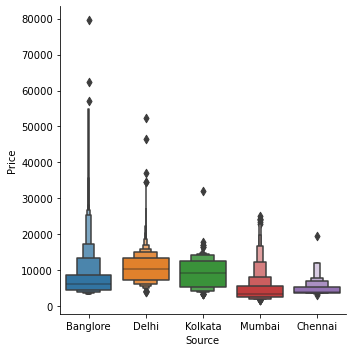

In [67]:
sns.catplot(x = "Source", y = "Price", data = df.sort_values(by = "Price", ascending=False), kind = "boxen")

As we can see from the two charts above, source and destinations of the passenger also contribute to flight price.

# Features Engineering 

I would separate the Date_of_Journey column to the day and month of journey

In [68]:
df["Day_of_Journey"] = df.Date_of_Journey.dt.day
df["Month_of_Journey"] = df.Date_of_Journey.dt.month

In [69]:
df.Dep_Time = pd.to_datetime(df.Dep_Time)
df.Arrival_Time = pd.to_datetime(df.Arrival_Time)

In [70]:
df["Dep_Hour"] = df.Dep_Time.dt.hour
df["Dep_Min"] = df.Dep_Time.dt.minute
df["Arrival_Hour"] = df.Arrival_Time.dt.hour
df["Arrival_Min"] = df.Arrival_Time.dt.minute

In [71]:
df.drop(columns=["Dep_Time", "Arrival_Time", "Duration", "Route", "Date_of_Journey","Additional_Info"], inplace=True)

In [72]:
df.Total_Stops = df.Total_Stops.replace({"non-stop":0, "1 stop":1, "2 stops":2, "3 stops":3, "4 stops":4})

# Modelling

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import ExtraTreesRegressor

In [74]:
X = df.copy()
X.drop(columns = ["Price"], inplace=True)
Y = df["Price"]

In [75]:
X = pd.get_dummies(X, drop_first=True)

In [134]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [135]:
models = { 'ExtraTree': {'model':ExtraTreesRegressor(), 'params':{'n_estimators':[100, 150, 200]}
                  
                  },
          
          'Random': {'model':RandomForestRegressor(), 'params':{'n_estimators': [100, 150, 200]}
              
          },
          
          'XGBoost': {'model':XGBRegressor(), 'params': {'eta': [0.1, 0.2, 0.3], "n_estimators" : [100, 200, 300]}
                      
                      },
    
    
}

In [136]:
scores_nw = []

for model_name, paras in models.items():
    gscv = GridSearchCV(paras['model'], paras['params'])
    gscv.fit(x_train, y_train)
    
    scores_nw.append({
        'model_names': model_name,
        'best_scores' : gscv.best_score_,
        'best_params' : gscv.best_params_
    })

In [137]:
pd.DataFrame(scores_nw)

,model_names,best_scores,best_params
0,ExtraTree,0.777462,{'n_estimators': 150}
1,Random,0.786403,{'n_estimators': 100}
2,XGBoost,0.815643,"{'eta': 0.1, 'n_estimators': 200}"


In [138]:
fold = StratifiedKFold(n_splits = 5)

In [139]:
from sklearn.model_selection import cross_val_score

In [140]:
cross_val_score(XGBRegressor(), X, Y)

array([0.84667001, 0.83824771, 0.86241724, 0.84049366, 0.78558563])

# Using Catboost 

In [141]:
cat = CatBoostRegressor()

In [142]:
cat.fit(x_train, y_train)

Learning rate set to 0.05688
0:	learn: 4478.1451425	total: 8.1ms	remaining: 8.09s
1:	learn: 4324.1613326	total: 15.9ms	remaining: 7.96s
2:	learn: 4181.7689917	total: 21ms	remaining: 6.98s
3:	learn: 4051.2028613	total: 25.8ms	remaining: 6.42s
4:	learn: 3925.2262808	total: 30.7ms	remaining: 6.12s
5:	learn: 3811.8056383	total: 35.6ms	remaining: 5.9s
6:	learn: 3706.9993507	total: 40.6ms	remaining: 5.75s
7:	learn: 3605.4462430	total: 45.3ms	remaining: 5.62s
8:	learn: 3512.5848706	total: 50.3ms	remaining: 5.54s
9:	learn: 3430.6537408	total: 55.1ms	remaining: 5.45s
10:	learn: 3357.2810641	total: 59.8ms	remaining: 5.38s
11:	learn: 3285.1587252	total: 64.6ms	remaining: 5.32s
12:	learn: 3218.9914049	total: 69.3ms	remaining: 5.26s
13:	learn: 3155.0382368	total: 73.9ms	remaining: 5.21s
14:	learn: 3099.6985704	total: 77.4ms	remaining: 5.08s
15:	learn: 3045.3252210	total: 80.4ms	remaining: 4.95s
16:	learn: 2996.5616712	total: 83.6ms	remaining: 4.83s
17:	learn: 2953.8087038	total: 86.5ms	remaining: 4

151:	learn: 2031.8074510	total: 489ms	remaining: 2.73s
152:	learn: 2030.7436919	total: 492ms	remaining: 2.72s
153:	learn: 2027.2848932	total: 496ms	remaining: 2.72s
154:	learn: 2022.8139639	total: 499ms	remaining: 2.72s
155:	learn: 2020.4908388	total: 502ms	remaining: 2.72s
156:	learn: 2018.0527868	total: 506ms	remaining: 2.71s
157:	learn: 2013.5299579	total: 511ms	remaining: 2.72s
158:	learn: 2012.6431033	total: 515ms	remaining: 2.72s
159:	learn: 2010.7415228	total: 518ms	remaining: 2.72s
160:	learn: 2007.4915742	total: 522ms	remaining: 2.72s
161:	learn: 2005.2592543	total: 525ms	remaining: 2.72s
162:	learn: 2002.6730080	total: 529ms	remaining: 2.72s
163:	learn: 2001.1779309	total: 533ms	remaining: 2.71s
164:	learn: 1997.1359848	total: 536ms	remaining: 2.71s
165:	learn: 1995.0261165	total: 539ms	remaining: 2.71s
166:	learn: 1992.7371445	total: 543ms	remaining: 2.71s
167:	learn: 1991.4505045	total: 546ms	remaining: 2.7s
168:	learn: 1988.8636894	total: 549ms	remaining: 2.7s
169:	learn: 

308:	learn: 1776.0585429	total: 983ms	remaining: 2.2s
309:	learn: 1774.7305106	total: 986ms	remaining: 2.19s
310:	learn: 1773.2658763	total: 990ms	remaining: 2.19s
311:	learn: 1772.2146906	total: 993ms	remaining: 2.19s
312:	learn: 1771.0365227	total: 997ms	remaining: 2.19s
313:	learn: 1770.7196865	total: 1s	remaining: 2.19s
314:	learn: 1769.1902274	total: 1s	remaining: 2.18s
315:	learn: 1768.1595129	total: 1.01s	remaining: 2.18s
316:	learn: 1767.6688351	total: 1.01s	remaining: 2.18s
317:	learn: 1767.3331055	total: 1.01s	remaining: 2.17s
318:	learn: 1766.5100697	total: 1.01s	remaining: 2.17s
319:	learn: 1766.3837250	total: 1.02s	remaining: 2.16s
320:	learn: 1764.7702307	total: 1.02s	remaining: 2.16s
321:	learn: 1763.7041021	total: 1.02s	remaining: 2.16s
322:	learn: 1763.3602304	total: 1.03s	remaining: 2.15s
323:	learn: 1762.5896536	total: 1.03s	remaining: 2.15s
324:	learn: 1761.6114513	total: 1.03s	remaining: 2.15s
325:	learn: 1760.3149210	total: 1.04s	remaining: 2.14s
326:	learn: 1760.

469:	learn: 1638.9347289	total: 1.48s	remaining: 1.67s
470:	learn: 1637.8017964	total: 1.48s	remaining: 1.67s
471:	learn: 1637.2288817	total: 1.49s	remaining: 1.66s
472:	learn: 1637.0815518	total: 1.49s	remaining: 1.66s
473:	learn: 1636.5728067	total: 1.49s	remaining: 1.66s
474:	learn: 1636.3243938	total: 1.5s	remaining: 1.65s
475:	learn: 1635.3699613	total: 1.5s	remaining: 1.65s
476:	learn: 1634.6693172	total: 1.5s	remaining: 1.65s
477:	learn: 1633.4505920	total: 1.5s	remaining: 1.64s
478:	learn: 1633.2949805	total: 1.51s	remaining: 1.64s
479:	learn: 1632.1891334	total: 1.51s	remaining: 1.64s
480:	learn: 1631.3991134	total: 1.51s	remaining: 1.63s
481:	learn: 1630.3432155	total: 1.52s	remaining: 1.63s
482:	learn: 1629.8074127	total: 1.52s	remaining: 1.63s
483:	learn: 1629.7640617	total: 1.52s	remaining: 1.62s
484:	learn: 1629.4236641	total: 1.52s	remaining: 1.62s
485:	learn: 1628.4458732	total: 1.53s	remaining: 1.62s
486:	learn: 1627.8655782	total: 1.53s	remaining: 1.61s
487:	learn: 16

632:	learn: 1536.0882068	total: 1.97s	remaining: 1.14s
633:	learn: 1535.6932609	total: 1.97s	remaining: 1.14s
634:	learn: 1535.0080856	total: 1.97s	remaining: 1.13s
635:	learn: 1534.4045884	total: 1.98s	remaining: 1.13s
636:	learn: 1533.8020548	total: 1.98s	remaining: 1.13s
637:	learn: 1533.2392413	total: 1.99s	remaining: 1.13s
638:	learn: 1532.5722838	total: 1.99s	remaining: 1.12s
639:	learn: 1532.4599798	total: 1.99s	remaining: 1.12s
640:	learn: 1531.8108806	total: 1.99s	remaining: 1.12s
641:	learn: 1531.3196912	total: 2s	remaining: 1.11s
642:	learn: 1530.8561855	total: 2s	remaining: 1.11s
643:	learn: 1530.2639499	total: 2s	remaining: 1.11s
644:	learn: 1529.3267922	total: 2s	remaining: 1.1s
645:	learn: 1528.8334668	total: 2.01s	remaining: 1.1s
646:	learn: 1528.3149434	total: 2.01s	remaining: 1.1s
647:	learn: 1528.2207196	total: 2.01s	remaining: 1.09s
648:	learn: 1527.9295384	total: 2.02s	remaining: 1.09s
649:	learn: 1527.3362763	total: 2.02s	remaining: 1.09s
650:	learn: 1526.9085381	

801:	learn: 1462.9751557	total: 2.47s	remaining: 609ms
802:	learn: 1462.4925083	total: 2.47s	remaining: 606ms
803:	learn: 1462.2862142	total: 2.47s	remaining: 603ms
804:	learn: 1462.0420593	total: 2.48s	remaining: 600ms
805:	learn: 1461.2693783	total: 2.48s	remaining: 597ms
806:	learn: 1460.8299416	total: 2.48s	remaining: 594ms
807:	learn: 1460.7693007	total: 2.49s	remaining: 591ms
808:	learn: 1460.4214730	total: 2.49s	remaining: 588ms
809:	learn: 1459.9749535	total: 2.49s	remaining: 585ms
810:	learn: 1459.6084623	total: 2.5s	remaining: 582ms
811:	learn: 1459.5344017	total: 2.5s	remaining: 579ms
812:	learn: 1459.4622499	total: 2.5s	remaining: 576ms
813:	learn: 1459.1599569	total: 2.5s	remaining: 572ms
814:	learn: 1458.5701519	total: 2.51s	remaining: 569ms
815:	learn: 1458.2575040	total: 2.51s	remaining: 566ms
816:	learn: 1457.8910467	total: 2.51s	remaining: 563ms
817:	learn: 1457.4906348	total: 2.52s	remaining: 560ms
818:	learn: 1457.2063789	total: 2.52s	remaining: 557ms
819:	learn: 14

964:	learn: 1406.8056320	total: 2.96s	remaining: 107ms
965:	learn: 1406.4075796	total: 2.96s	remaining: 104ms
966:	learn: 1405.8814965	total: 2.96s	remaining: 101ms
967:	learn: 1405.6233460	total: 2.97s	remaining: 98.2ms
968:	learn: 1405.3239426	total: 2.97s	remaining: 95.1ms
969:	learn: 1404.9869311	total: 2.98s	remaining: 92.1ms
970:	learn: 1404.5399618	total: 2.98s	remaining: 89ms
971:	learn: 1404.2935723	total: 2.98s	remaining: 85.9ms
972:	learn: 1404.0819207	total: 2.99s	remaining: 82.9ms
973:	learn: 1403.9839340	total: 2.99s	remaining: 79.8ms
974:	learn: 1403.4854174	total: 2.99s	remaining: 76.7ms
975:	learn: 1403.2197407	total: 2.99s	remaining: 73.6ms
976:	learn: 1403.0053542	total: 3s	remaining: 70.6ms
977:	learn: 1402.8802591	total: 3s	remaining: 67.5ms
978:	learn: 1402.8032936	total: 3s	remaining: 64.4ms
979:	learn: 1402.4359153	total: 3.01s	remaining: 61.4ms
980:	learn: 1402.0185056	total: 3.01s	remaining: 58.3ms
981:	learn: 1401.9889229	total: 3.01s	remaining: 55.2ms
982:	l

In [143]:
cat.score(x_test, y_test)

0.8578679203009218

# Training using the chosen model

In [165]:
model = XGBRegressor()

In [166]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [167]:
model.score(x_test, y_test)

0.8456717283991857

In [170]:
x_test_new = x_test.copy()
x_test_new["Actual_values"] = y_test
x_test_new["Predicted_Values"] = model.predict(x_test)

In [175]:
x_test_new[["Actual_values","Predicted_Values"]]

,Actual_values,Predicted_Values
6075,16655,16585.501953
3544,4959,6277.790527
9291,9187,8411.381836
5032,3858,3752.216309
2483,12898,14150.290039
...,...,...
3022,13555,13172.394531
8416,12760,16868.843750
2605,3419,3473.146484
1392,5797,8084.793457
